In [12]:
from tensorflow.keras import models, layers, optimizers, callbacks
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=150
import time
import pickle
import sys
from memory_profiler import profile

In [2]:
#x_train = np.loadtxt("c_train.txt")  
#y_train = np.loadtxt("s_train.txt")  
#x_test = np.loadtxt("c_test.txt")  
#y_test = np.loadtxt("s_test.txt")  
w0 = np.loadtxt( "frequencies.txt" )

x_train = np.loadtxt("c_train_1_over_f_2.txt")  
y_train = np.loadtxt("s_train_1_over_f_2.txt")  
x_test = np.loadtxt("c_test_1_over_f_2.txt")  
y_test = np.loadtxt("s_test_1_over_f_2.txt") 

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))


x_train =  (30200, 147)
y_train =  (30200, 501)
x_test =  (6040, 147)
y_test =  (6040, 501)
w0 =  (501,)


In [3]:
def get_model( filter_nb, kernel_size, pool_size, learning_rate, dropout_rate ):
    model = models.Sequential()
    model.add( layers.Input( shape=(x_train.shape[-1], 1) ) )
    #model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.MaxPooling1D( pool_size=pool_size, padding="same") )
    
    model.add( layers.Conv1D(filter_nb//4,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D(filter_nb//2,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.UpSampling1D( size=pool_size ) )
    
    model.add( layers.Conv1D(filter_nb,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Conv1D(1,kernel_size,activation="relu", padding='same' ) )
    model.add( layers.Flatten() )
    model.add( layers.Dropout( dropout_rate ) )
    model.add( layers.Dense(501, activation='linear') )
    
    opt = optimizers.Adam(learning_rate=learning_rate)
    #model.compile(loss='mean_squared_error', optimizer=opt)
    model.compile(loss='MAPE', optimizer=opt)
    
    return model 

In [4]:
model = get_model( filter_nb=20, kernel_size=31, pool_size=2,\
                          learning_rate=0.001, dropout_rate=0.05 )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 20)           640       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 20)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 74, 10)            6210      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 10)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 37, 5)             1555      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19, 5)            0

In [5]:
t1 = time.time()
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.25,patience=5,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-6)

model = get_model( filter_nb=20, kernel_size=31, pool_size=2,\
                      learning_rate=0.001, dropout_rate=0.05 )
history_ = model.fit( x_train, y_train, 64, epochs=80,\
                         validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

print(time.time()-t1)

Epoch 1/80
472/472 [==============================] - 11s 21ms/step - loss: 62.6510 - val_loss: 38.9416 - lr: 0.0010
Epoch 2/80
472/472 [==============================] - 9s 20ms/step - loss: 34.3658 - val_loss: 25.6868 - lr: 0.0010
Epoch 3/80
472/472 [==============================] - 9s 20ms/step - loss: 24.6444 - val_loss: 25.7016 - lr: 0.0010
Epoch 4/80
472/472 [==============================] - 9s 20ms/step - loss: 20.7134 - val_loss: 19.0339 - lr: 0.0010
Epoch 5/80
472/472 [==============================] - 9s 20ms/step - loss: 19.2139 - val_loss: 21.8094 - lr: 0.0010
Epoch 6/80
472/472 [==============================] - 9s 20ms/step - loss: 17.6555 - val_loss: 21.1292 - lr: 0.0010
Epoch 7/80
472/472 [==============================] - 9s 20ms/step - loss: 16.7136 - val_loss: 17.0071 - lr: 0.0010
Epoch 8/80
472/472 [==============================] - 9s 20ms/step - loss: 15.8611 - val_loss: 17.4928 - lr: 0.0010
Epoch 9/80
472/472 [==============================] - 9s 20ms/step - lo

472/472 [==============================] - 10s 20ms/step - loss: 8.1787 - val_loss: 8.2240 - lr: 3.9063e-06
Epoch 66/80
472/472 [==============================] - 10s 20ms/step - loss: 8.1813 - val_loss: 8.3182 - lr: 3.9063e-06
Epoch 67/80
472/472 [==============================] - 10s 20ms/step - loss: 8.1845 - val_loss: 8.2092 - lr: 3.9063e-06
Epoch 68/80
472/472 [==============================] - ETA: 0s - loss: 8.1802
Epoch 68: ReduceLROnPlateau reducing learning rate to 1e-06.
472/472 [==============================] - 10s 20ms/step - loss: 8.1802 - val_loss: 8.2147 - lr: 3.9063e-06
Epoch 69/80
472/472 [==============================] - 10s 20ms/step - loss: 8.1642 - val_loss: 8.2194 - lr: 1.0000e-06
Epoch 70/80
472/472 [==============================] - 9s 20ms/step - loss: 8.1612 - val_loss: 8.2843 - lr: 1.0000e-06
Epoch 71/80
472/472 [==============================] - 10s 20ms/step - loss: 8.1618 - val_loss: 8.1881 - lr: 1.0000e-06
Epoch 72/80
472/472 [=========================

Text(0, 0.5, 'Loss')

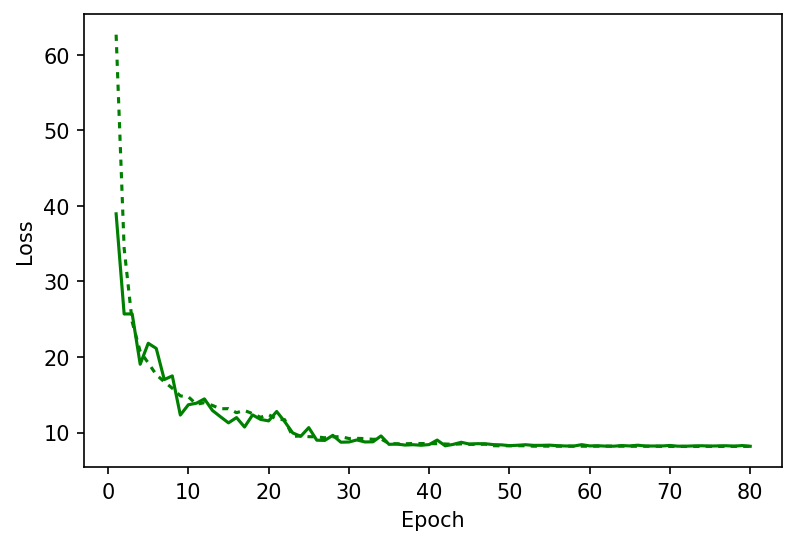

In [25]:
plt.plot( range(1,80+1 ), np.array(history_.history['loss']), dashes=[2,2,2,2],label='loss', c='green')
plt.plot( range(1,80+1 ), np.array(history_.history['val_loss']), label = 'val_loss', c='green')

plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0.5, 1])
#plt.legend(loc='lower right')

In [18]:
label1 = 'number_of_filters'
label2 = 'kernel_size'

parameters1_arr = np.arange( 20,80 )  #-- number of filters
parameters2_arr = np.arange( 16,48 )  #-- kernel size
pairs = []
for p1 in parameters1_arr:
    for p2 in parameters2_arr:
        pairs.append([p1,p2])
        
training_losses = {}
validation_losses = {}

nb_of_points = len(parameters1_arr)*len(parameters2_arr)
print(label1, parameters1_arr)
print(label2, parameters2_arr)
print(len(parameters1_arr),len(parameters2_arr),nb_of_points)

number_of_filters [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79]
kernel_size [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45 46 47]
60 32 1920


In [20]:
epochs=20
best_loss = 1000
worst_loss = -1

t1=time.time()
print('-- nb of points =',nb_of_points_in )

from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d_%m||%Hh%M")

if (nb_of_points_in != len(pairs_in)):
print("-- ABORT: parameter sweep already started.")
sys.exit()

reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.5,patience=5,verbose=0,\
mode="auto",min_delta=0.001,cooldown=0,min_lr=1e-5)

count=0
while pairs_in:
count +=1
rand_int = np.random.randint(0, len(pairs_in))
pair = pairs_in[rand_int]
p1 = int( pair[0] )
p2 = int( pair[1] )
pairs_in.remove(pair)

print('.',end=' ' )
model = get_model( filter_nb=p1, kernel_size=p2, pool_size=2,\
                  learning_rate=0.001, dropout_rate=0.05 )
history_ = model.fit( x_train, y_train, 64, epochs=epochs,\
                     validation_data=(x_test, y_test), verbose=0, callbacks=[reduce_lr])

training_losses[ p1 , p2 ] = history_.history['loss'][-1]
validation_losses[ p1 ,p2 ] = history_.history['val_loss'][-1]
if count > 20:
    with open('training/training_losses_'+t_string+'.pkl', 'wb') as f1:
        pickle.dump(training_losses, f1)
    with open('training/validation_losses_'+t_string+'.pkl', 'wb') as f2:
        pickle.dump(validation_losses, f2)

if validation_losses[ p1 , p2 ] < best_loss:
    best_history = history_.history
    if count > 20:
        with open('training/best_history_'+t_string+'.pkl', 'wb') as f3:
            pickle.dump(best_history, f3)
    best_loss = validation_losses[ p1 , p2 ]
    best_model = model
    best_p1=p1
    best_p2=p2

del model
del history_

if count>3:
    break


t2=time.time()
print(' ')
print('=== COMPLETE ===')
print("-- total time = ", t2-t1)
print("-- best {}, {} =".format(label1, label2), best_p1, best_p2)
print("-- t_string", t_string)

return t_string, best_model

In [22]:
train(nb_of_points, pairs)

ERROR: Could not find file <ipython-input-20-fab724c5f600>
NOTE: %mprun can only be used on functions defined in physical files, and not in the IPython environment.
-- nb of points = 1920
. 

KeyboardInterrupt: 

Best parameters = 79 30


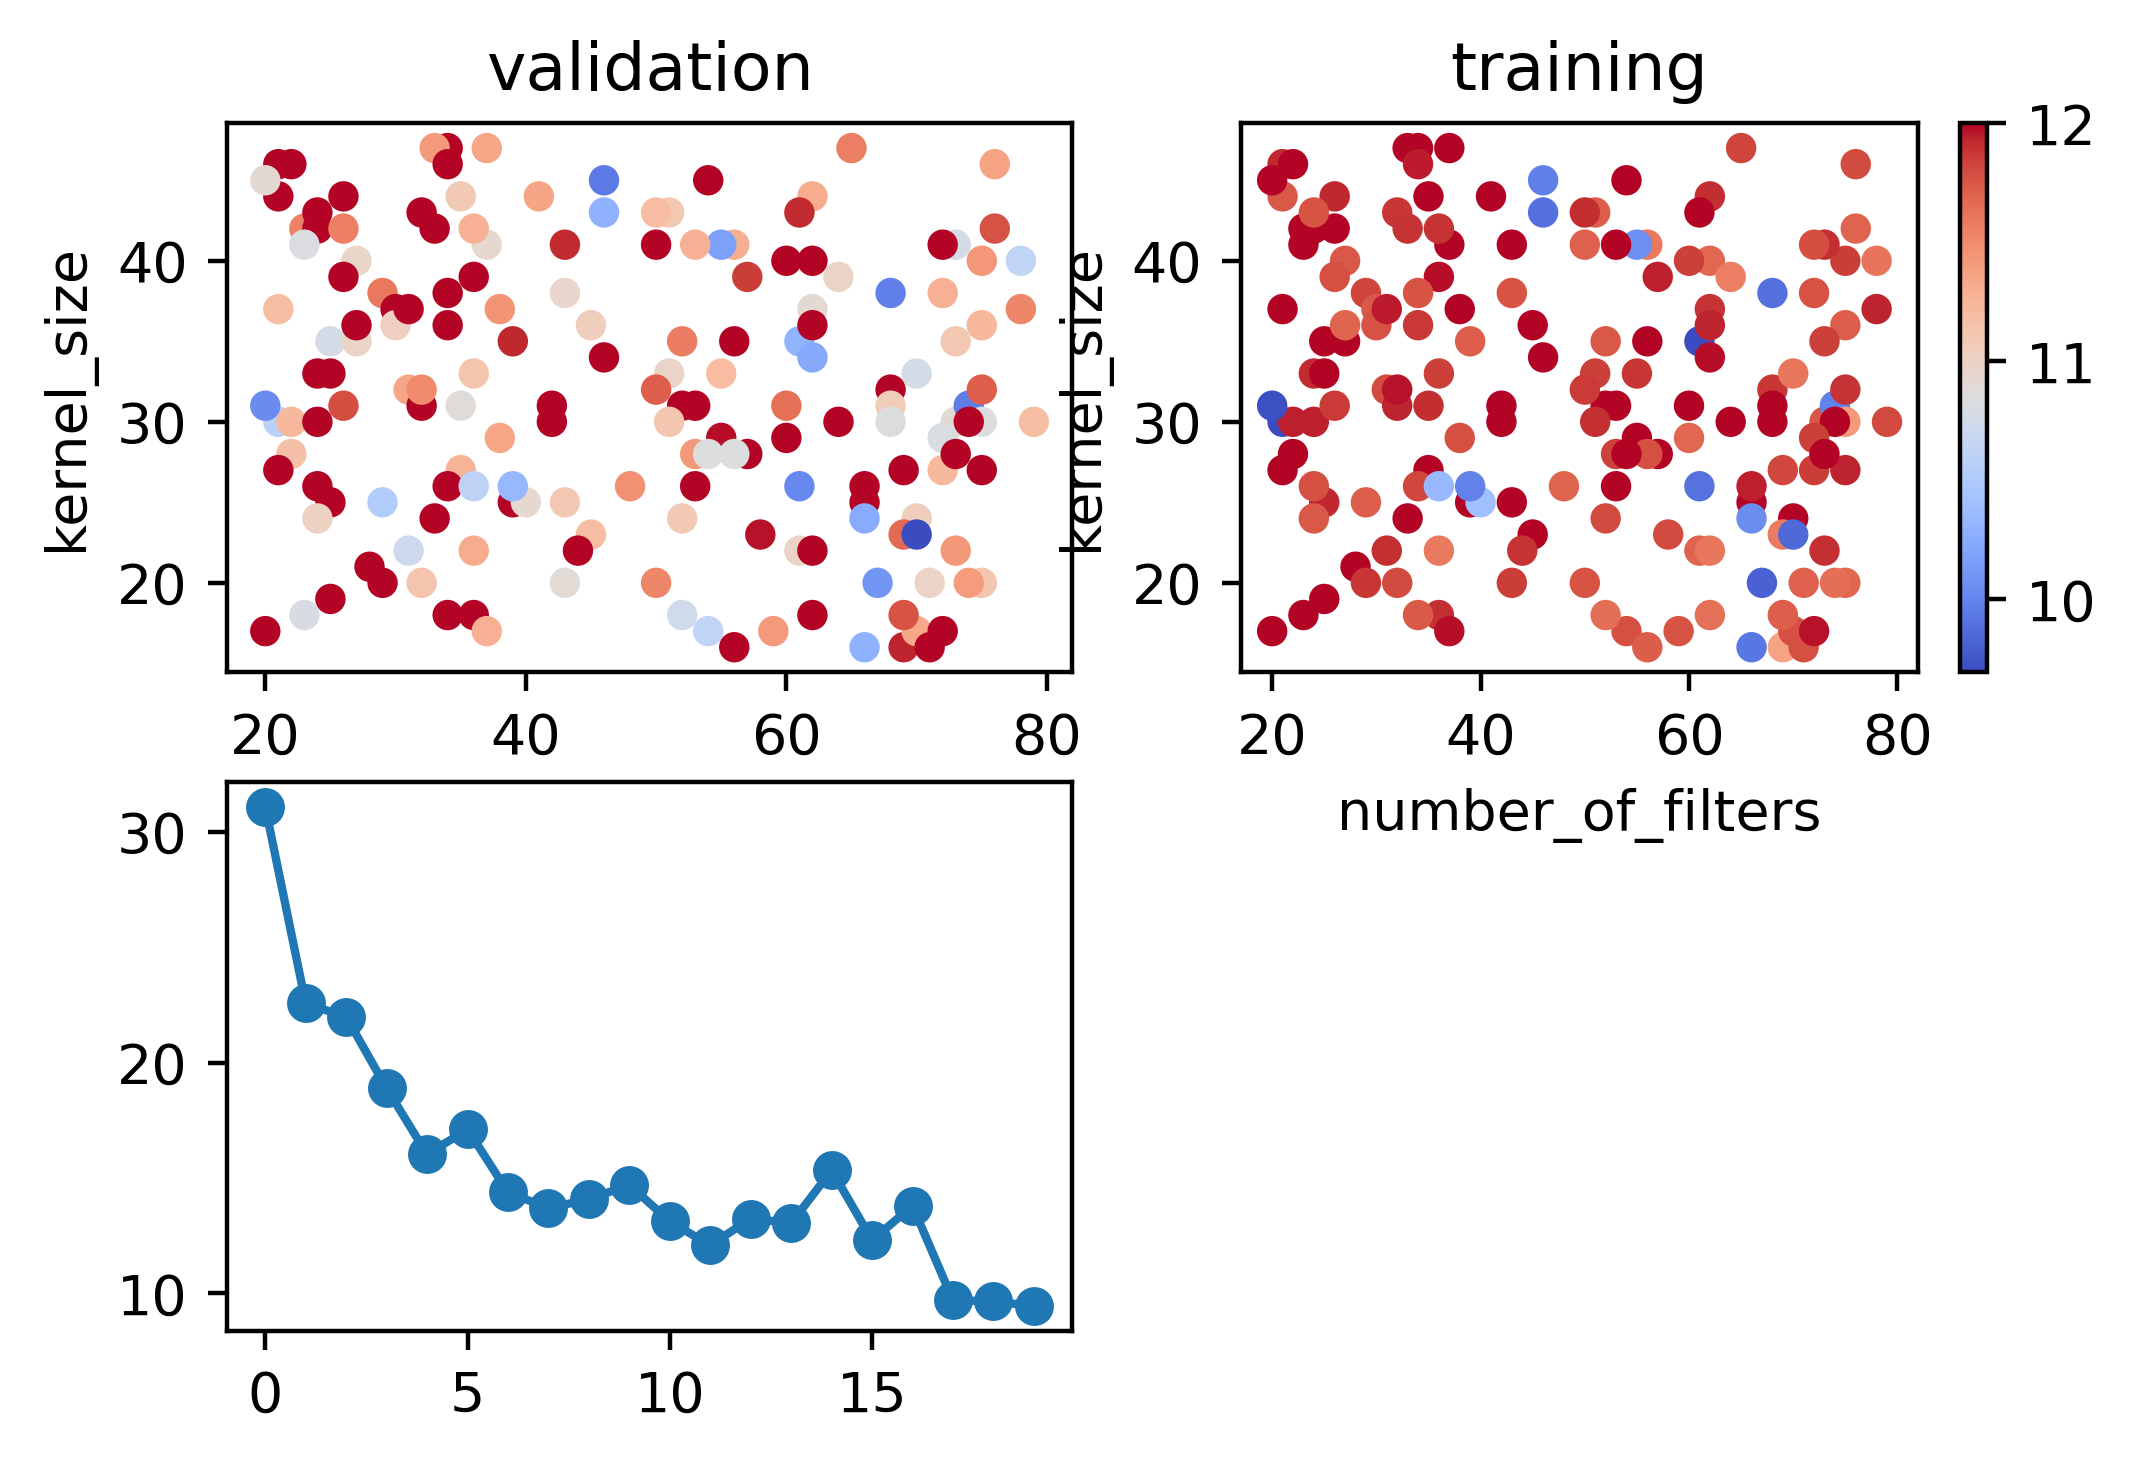

In [15]:
matplotlib.rcParams['figure.dpi']=400
#t_string="24_04||11h20"
with open('training/training_losses_'+t_string+'.pkl', 'rb') as f1:
    training_losses = pickle.load(f1)
with open('training/validation_losses_'+t_string+'.pkl', 'rb') as f2:
    validation_losses = pickle.load(f2)
with open('training/best_history_'+t_string+'.pkl', 'rb') as f3:
    best_history = pickle.load(f3)


max_val = max(validation_losses)
print( "Best parameters =", max_val[0], max_val[1] )

x_scatter = [ x[0] for x in training_losses]
y_scatter = [ x[1] for x in training_losses]
training_colors = [training_losses[x] for x in training_losses]
validation_colors = [validation_losses[x] for x in training_losses]


plt.subplot(2,2,1)
mycmap = plt.cm.coolwarm
lognorm=matplotlib.colors.LogNorm()
vals = list(validation_losses.values())
plt.scatter( x_scatter, y_scatter, s=20, c=validation_colors, cmap=mycmap)#,norm=lognorm )
plt.xlabel(label1)
plt.ylabel(label2)
plt.title( 'validation' )
plt.clim( min(vals), 12  )

plt.subplot(2,2,2)
vals = list(training_losses.values())
lognorm=matplotlib.colors.LogNorm()
mycmap = plt.cm.coolwarm
plt.scatter( x_scatter, y_scatter, s=20, c=training_colors, cmap=mycmap)#,norm=lognorm )
plt.xlabel(label1)
plt.ylabel(label2)
plt.title( 'training' )
plt.clim( min(vals), 12  )
plt.colorbar()

plt.subplot(2,2,3)
plt.scatter( np.arange(len(best_history['val_loss'])), best_history['val_loss'] )
plt.plot( np.arange(len(best_history['val_loss'])), best_history['val_loss'] )
plt.savefig('training/plots/'+t_string+'.pdf',format='pdf')
plt.show()



In [3]:
validation_losses

{(0.001501294382346335, 0.13): 13.149602890014648,
 (0.0005244821276615173, 0.05): 12.41899585723877,
 (0.0005244821276615173, 0.0): 10.645764350891113,
 (0.0006349995991170712, 0.07): 12.812763214111328}

In [37]:
training_losses

{(0.006210169418915616, 162): 73.90043640136719,
 (0.008531678524172805, 172): 69.760009765625,
 (0.0002592943797404667, 152): 97.88495635986328}

In [7]:
probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

189/189 [==============================] - 1s 5ms/step


NameError: name 'best_lr' is not defined

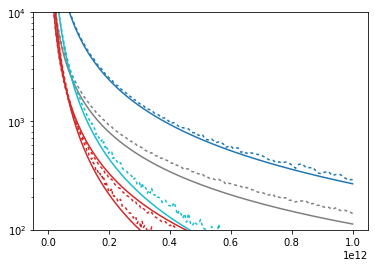

In [8]:
plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e4)
plt.title('lr,dr=  '+str(best_lr)+"  "+str(best_bs) )

In [1]:
1/2


0.5

In [2]:
4/2

2.0

In [9]:
48/8

6.0

In [19]:
np.shape( x_train )

(6067, 147)

In [22]:
x_train.shape[0]

6067

In [29]:
training_losses

{(0.0038566204211634724, 142): 96.98180389404297,
 (0.001082636733874054, 52): 11.408679008483887,
 (0.006210169418915616, 192): 96.67304992675781,
 (0.0020433597178569417, 242): 62.887176513671875,
 (0.0007880462815669912, 112): 12.717473983764648,
 (0.0002592943797404667, 72): 13.815680503845215,
 (0.0014873521072935117, 182): 13.786232948303223,
 (0.01, 102): 94.4941177368164,
 (0.002395026619987486, 222): 98.4046859741211,
 (0.0012689610031679222, 142): 13.587713241577148,
 (0.0004893900918477494, 152): 15.693471908569336,
 (0.00016102620275609394, 82): 17.357421875,
 (0.00011721022975334806, 192): 34.889888763427734,
 (0.00018873918221350977, 52): 13.447169303894043,
 (0.0038566204211634724, 152): 97.09774017333984,
 (0.0009236708571873865, 62): 12.047370910644531,
 (0.0002592943797404667, 132): 18.657812118530273,
 (0.0017433288221999873, 92): 13.327167510986328,
 (0.0003039195382313198, 72): 13.556891441345215,
 (0.008531678524172805, 42): 92.83271026611328,
 (0.0012689610031679

In [40]:
np.random.randint(1e6)

464375

In [46]:
from datetime import datetime
now = datetime.now()
t_string = now.strftime("%d/%m %H:%M").replace(' ','_')

'24/04_04:54'

In [19]:
print("-- best {}, {} =".format(label1, label2) )

-- best number of filters, kernel size =


In [24]:
my_variable1 = 20
my_variable2 = "GeeksForGeeks"
  
# check if my_variable1 and my_variable2 exists
print(my_variable1)
print(my_variable2)
  
# delete both the variables
del my_variable1
del my_variable2
  
# check if my_variable1 and my_variable2 exists
print(my_variable2)

20
GeeksForGeeks


NameError: name 'my_variable2' is not defined